### Description:

In this task you will work with software AES-128 running on ESP32. 

You have access to plaintexts, ciphertexts and associated traces.
Oscilloscope snapshot (see below) shows an entire AES execution. You will have only the part related to the beginning of encryption.

The measurements were performed with LeCroy WaveRunner Zi625 and a differential probe

### Tips:

A 'trace' is a side-channel information measured between the VCC and the GND pins of the WROOM module (ESP32). 

In this example a trace is a 50000 bytes long array of int8 (the amplitude of the measured voltage).

This array contains various encryption information measured with noise.

### Task:

You will have several tasks this time, they are all describe below.


The master key is in the form of SCA{XXXXXXXXXXX}, where X is a ASCII printable symbol.

### AES-128 encryption measured at high sampling rate

Green signal - a GPIO trigger used to synchronize all the traces

Red signal   - VCC voltage variation during AES-128 encryption

<img src="support/osc_snap.png">

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sca_training
import time
import datetime
from tqdm import tqdm
from multiprocessing import Pool
from functools import partial

%matplotlib inline

In [2]:
numfiles    = 10
numtraces_per_file = 1000

numtraces   = 10000
numsamples  = 50000

#----------------------------------------------------------------------------
# OUTPUTS:
#     ptexts   - input plaintexts converted to numpy array of uint8
#     ctexts   - resulted ciphertext converted to numpy array of uint8
#     traces   - a trace associated with encryption process
#----------------------------------------------------------------------------

def ReadData():
    global numtraces
    global numsamples
    global numfiles
    global numtraces_per_file

    traces = np.zeros((numtraces, numsamples), dtype = np.int8)
    ptexts = np.zeros((numtraces, 16), dtype = np.uint8)
    ctexts = np.zeros((numtraces, 16), dtype = np.uint8)

    print('Reading data...')
    for i_file in range(numfiles):
        h5file = r'../data/aes_{}'.format(i_file * numtraces_per_file) + r'.hdf5'
        print('Reading {}...'.format(h5file))

        with h5py.File(h5file, 'r') as hdf5_file:
            ptexts[(i_file*numtraces_per_file):((i_file + 1)*numtraces_per_file),:] = hdf5_file['ptexts'][:,:].astype('uint8')
            ctexts[(i_file*numtraces_per_file):((i_file + 1)*numtraces_per_file),:] = hdf5_file['ctexts'][:,:].astype('uint8')
            traces[(i_file*numtraces_per_file):((i_file + 1)*numtraces_per_file),:] = hdf5_file['traces'][:,:].astype('int8')


    print('Ptexts size:', ptexts.shape)
    print(ptexts)
    print('Ctexts size:', ctexts.shape)
    print(ctexts)
    print('Traces size:', traces.shape)
    print(traces)
    print('Completed')

    return ptexts, ctexts, traces

In [3]:
ptexts, ctexts, traces = ReadData()

Reading data...
Reading ../data/aes_0.hdf5...
Reading ../data/aes_1000.hdf5...
Reading ../data/aes_2000.hdf5...
Reading ../data/aes_3000.hdf5...
Reading ../data/aes_4000.hdf5...
Reading ../data/aes_5000.hdf5...
Reading ../data/aes_6000.hdf5...
Reading ../data/aes_7000.hdf5...
Reading ../data/aes_8000.hdf5...
Reading ../data/aes_9000.hdf5...
Ptexts size: (10000, 16)
[[223  76 170 ...   3 242 135]
 [223  76 170 ...   3 242 135]
 [147  55  27 ... 208 136 153]
 ...
 [232  50 156 ... 197   2 113]
 [180  37 106 ... 173 208 252]
 [209  92 189 ...  30 163 224]]
Ctexts size: (10000, 16)
[[ 66  91  61 ... 225 145 183]
 [ 66  91  61 ... 225 145 183]
 [189 102 147 ... 196 215  14]
 ...
 [208 111  37 ... 120 115 246]
 [156  26 208 ... 207 125 147]
 [ 15  44  11 ... 235 169  58]]
Traces size: (10000, 50000)
[[35 20 39 ... 19 20 26]
 [29 26 41 ...  9 38 34]
 [12 42 41 ... 18 40 14]
 ...
 [35 25 42 ... 14 20 27]
 [26 27 42 ... 11 25 37]
 [21 25 44 ... 22 39 18]]
Completed


(9796, 50000)
(9796, 16)
(9796, 16)
(9796, 50000)


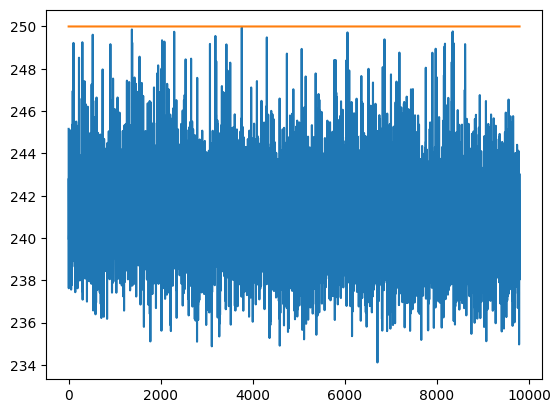

In [4]:
vars = np.var(traces, axis=1)

threshold = 250
mask = vars < threshold
clean_traces = traces[mask]
clean_plains = ptexts[mask]
clean_ciphers = ctexts[mask]
print(clean_traces.shape)
print(clean_plains.shape)
print(clean_ciphers.shape)

vars = np.var(clean_traces, axis=1)
plt.plot(vars)
_ = plt.plot([threshold]*len(vars))

# Center traces
clean_traces = np.array([t - np.mean(t) for t in clean_traces])
print(clean_traces.shape)

### Task

Find the master key

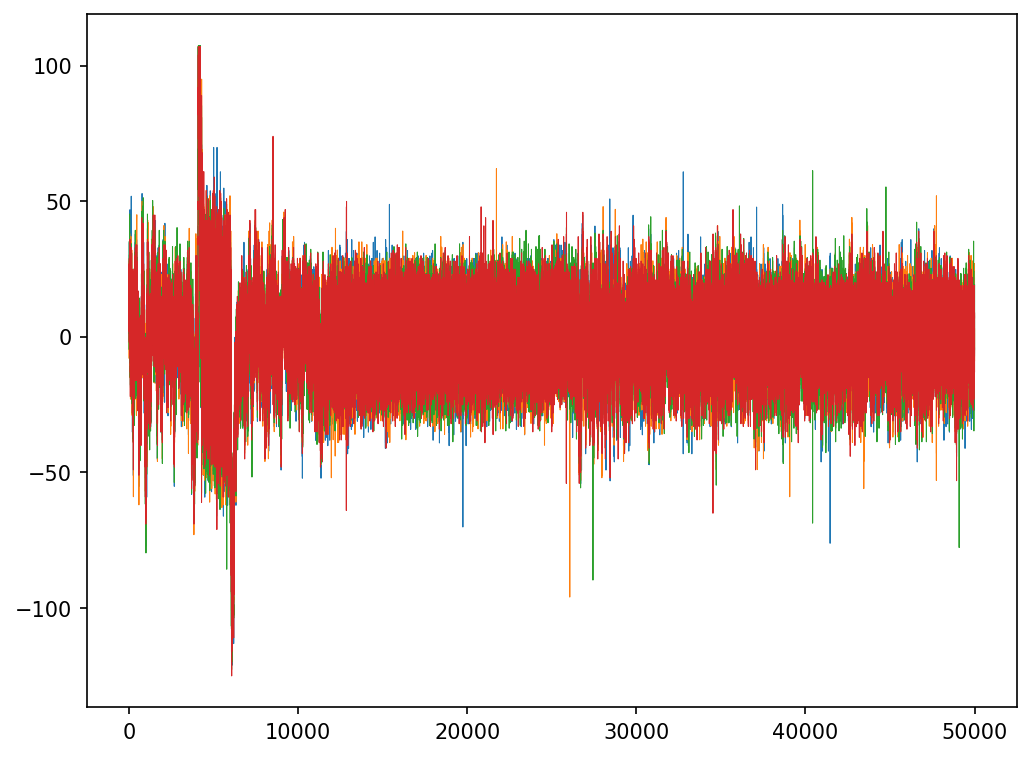

In [5]:
plt.rcParams['figure.figsize'] = (8.0,6.0)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['lines.linewidth'] = 0.5

plt.plot(np.transpose(clean_traces[5:9,:]))
plt.show()

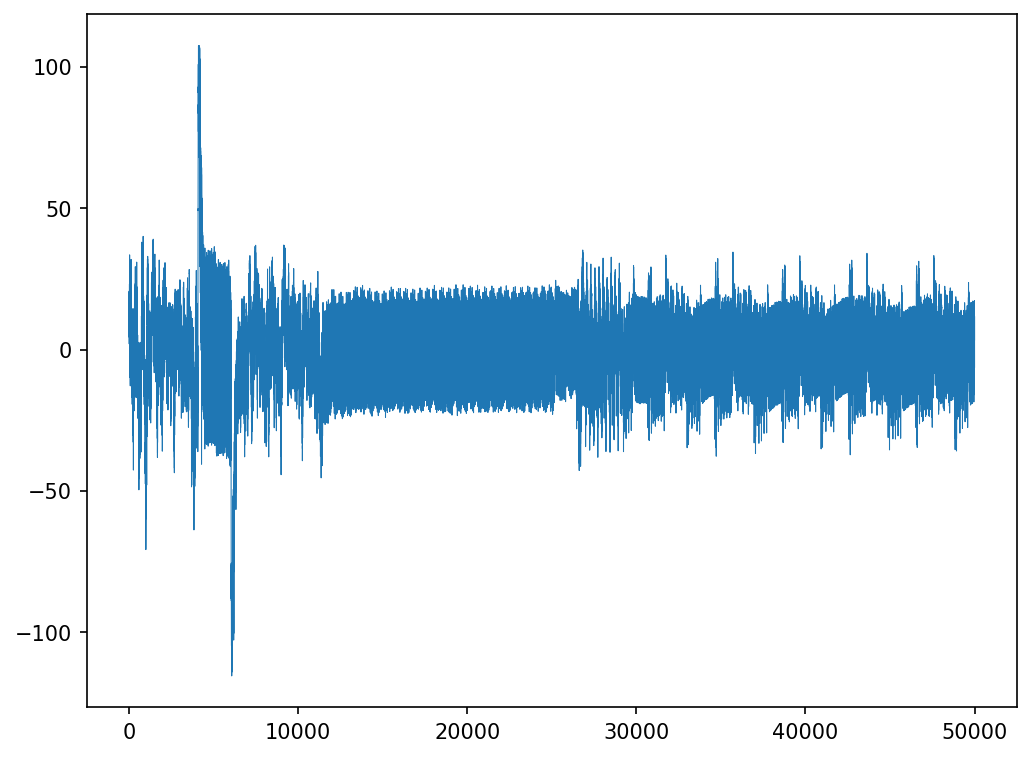

In [6]:
plt.plot(np.mean(clean_traces, axis=0))

In [7]:
print(clean_plains.shape)
hw_ptext = sca_training.HW_uint8[clean_plains]
print(hw_ptext.shape)
#hw_ctext = sca_training.HW_uint8[clean_ciphers]

print(clean_traces.shape)
pcc_hw_ptext = sca_training.compute_correlation(clean_traces, hw_ptext, model_block_size=16, samples_block_size=50, verbose = True)
print(pcc_hw_ptext.shape)
#pcc_hw_ctext = sca_training.compute_correlation(clean_traces, hw_ctext, model_block_size=16, samples_block_size=50, verbose = True)

(9796, 16)
(9796, 16)
(9796, 50000)
Start PCC computation
End PCC computation
(50000, 16)


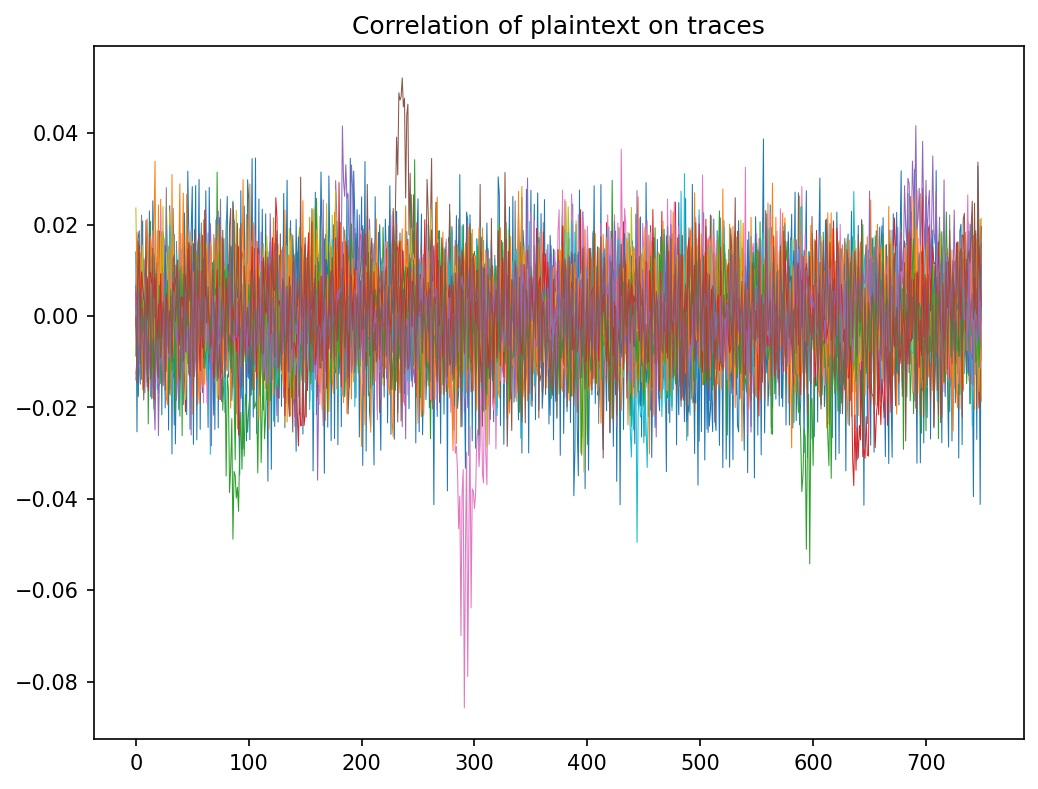

In [114]:
# Framing samples

# 1500 ou 1200
start = 29900
end = 30650

plt.title("Correlation of plaintext on traces")
if True:
    _ = [plt.plot(corr) for corr in pcc_hw_ptext.T[:,start:end]]
else:
    _ = [plt.plot(corr) for corr in pcc_hw_ptext.T]

framed_traces = clean_traces[:,start:end]
#framed_traces = np.array([t - np.mean(t) for t in framed_traces])

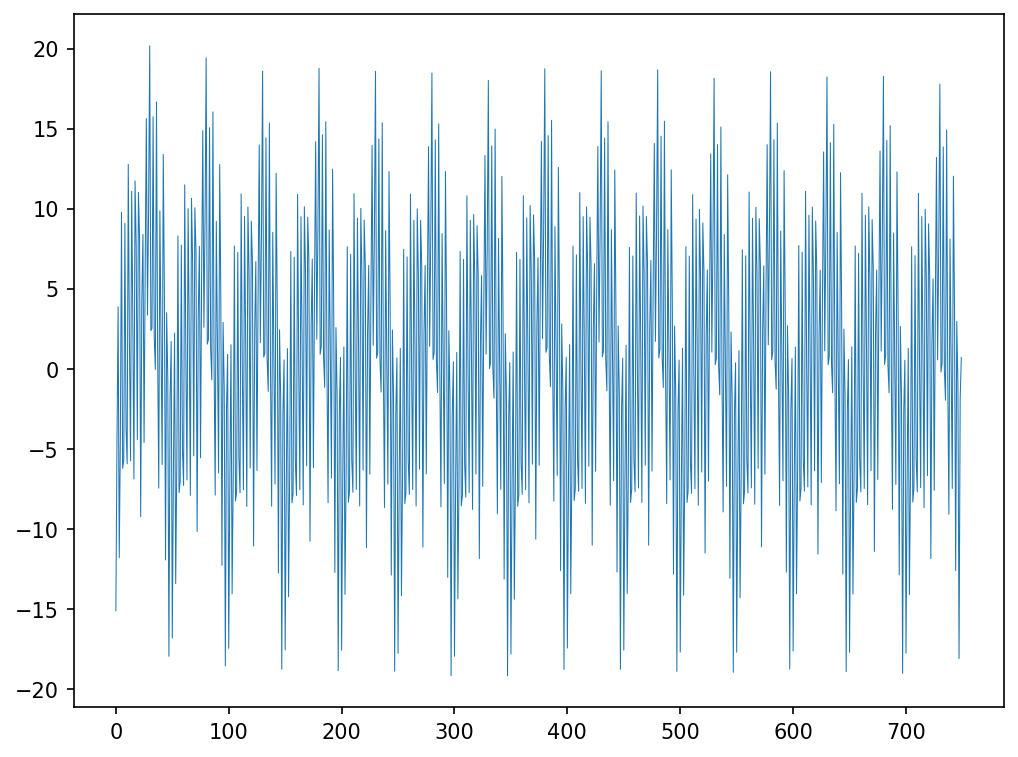

In [115]:
plt.plot(np.mean(framed_traces, axis=0))

(9796, 16000)


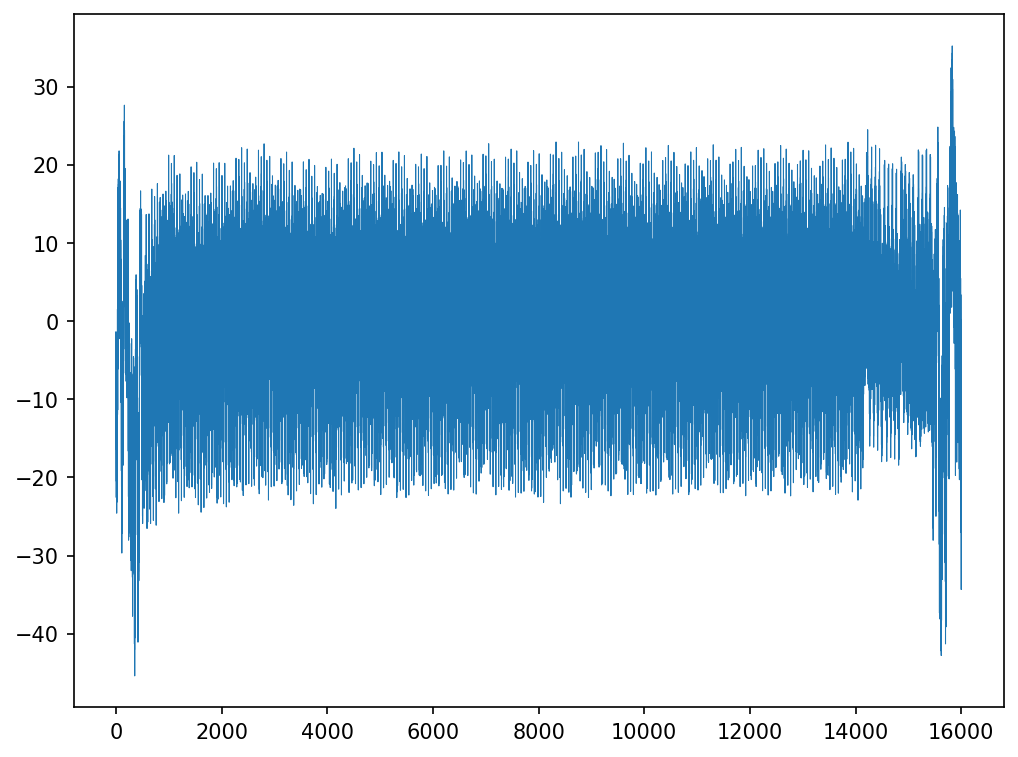

In [10]:
# Framing sample of new sbox computation with mask
start = 11000
end = 27000
framed_sbox = clean_traces[:,start:end]
#framed_sbox = np.array([t - np.mean(t) for t in framed_sbox])
plt.plot(np.mean(framed_sbox,axis=0))
print(framed_sbox.shape)

In [116]:
print(framed_traces.shape)
#print(framed_sbox.shape)
print(clean_plains.shape)

target_sbox = framed_traces.T
#target_m = framed_sbox.T
target_plain = clean_plains.T

(9796, 750)
(9796, 16)


In [78]:
import defs

def attack(candidates, plains, ms, traces, i):
    max_pcc = 0
    corrs = []
    mk = 0
    max_im = 0

    for k in candidates:
        tmp_plains = sca_training.Sbox[np.bitwise_xor(plains[i], k)]
        for m in ms:
            cand = sca_training.HW_uint8[np.bitwise_xor(tmp_plains, m)]
            all_corr = defs.matrix_corrcoef(traces, cand)
            pcc = max(all_corr)
            if pcc > max_pcc:
                max_pcc = pcc
                corrs = all_corr
                mk = k
                max_im = m

    return max_pcc, corrs, mk, max_im

In [117]:
corrs = []
tmp_cand = sca_training.Sbox[np.bitwise_xor(target_plain[0], ord('S'))]
for m in tqdm(range(256)):
    cand = sca_training.HW_uint8[np.bitwise_xor(tmp_cand, m)]
    corrs.append(defs.matrix_corrcoef(target_sbox, cand))
corrs = np.array(corrs)

100%|██████████| 256/256 [00:18<00:00, 13.82it/s]


(256, 750)
0.1697735446159783
0.1697735446159783
0.16977354461597824


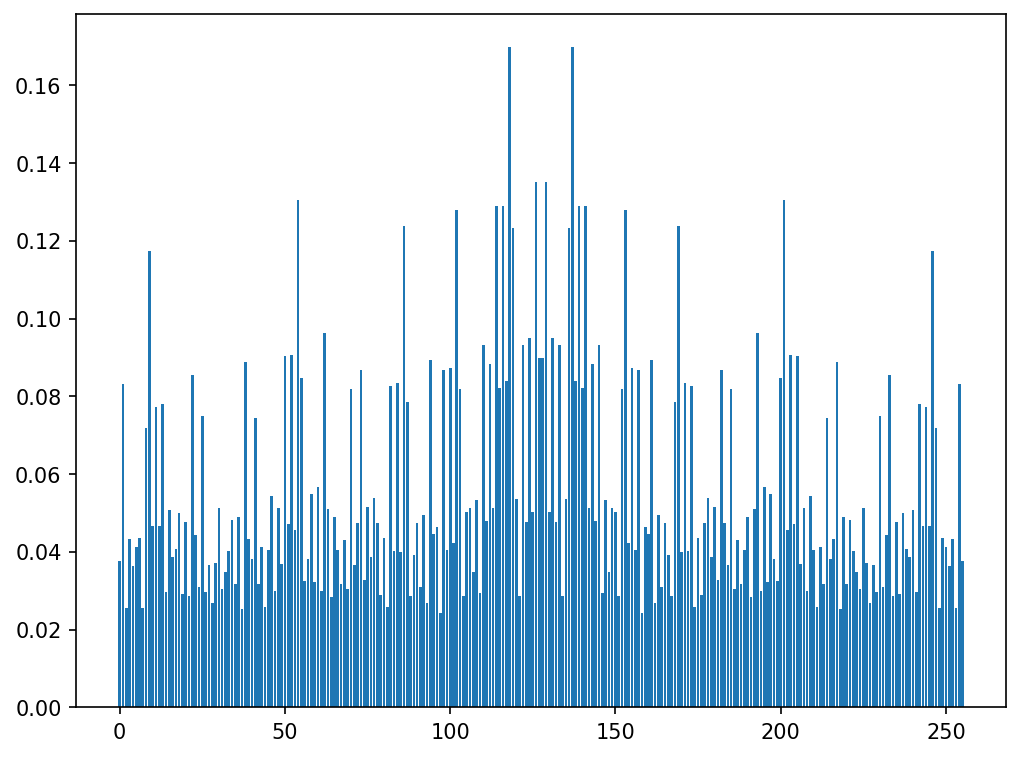

In [118]:
print(corrs.shape)
maxs = [max(corr) for corr in corrs]
plt.bar(range(256),maxs)
print(max(maxs))
print(maxs[118])
print(maxs[137])

In [119]:
#from defs import attack

idx = range(16)#range(4,15)
candidates = range(32,127)
ms = [118]#137#range(256)

mk = [0]*16
corrs = [[] for _ in range(16)]
pccs = [0]*16
ims = [0]*16
#mk[0] = ord('S')
#mk[1] = ord('C')
#mk[2] = ord('A')
#mk[3] = ord('{')
#mk[-15] = ord('}')

#pool = Pool(len(idx))

nb_gliss = 16
times = [0]*nb_gliss
it = 0

for i in tqdm(idx):
    # max_pcc, corrs, mk, max_im
    res = attack(candidates, target_plain, ms, target_sbox, i)
    pccs[i] = res[0]
    corrs[i] = res[1]
    mk[i] = res[2]
    ims[i] = res[3]

100%|██████████| 16/16 [01:48<00:00,  6.80s/it]


In [120]:
# Print awesome key
#k_flag = sca_training.inverse_key_expansion(np.array(k10_max))[0][0] # Last round
k_flag = mk # First round

# SCA{trkysbOXcaT}

flag = ''.join(chr(c) for c in k_flag)
print(flag)

SCA{trkysbOXcaT}


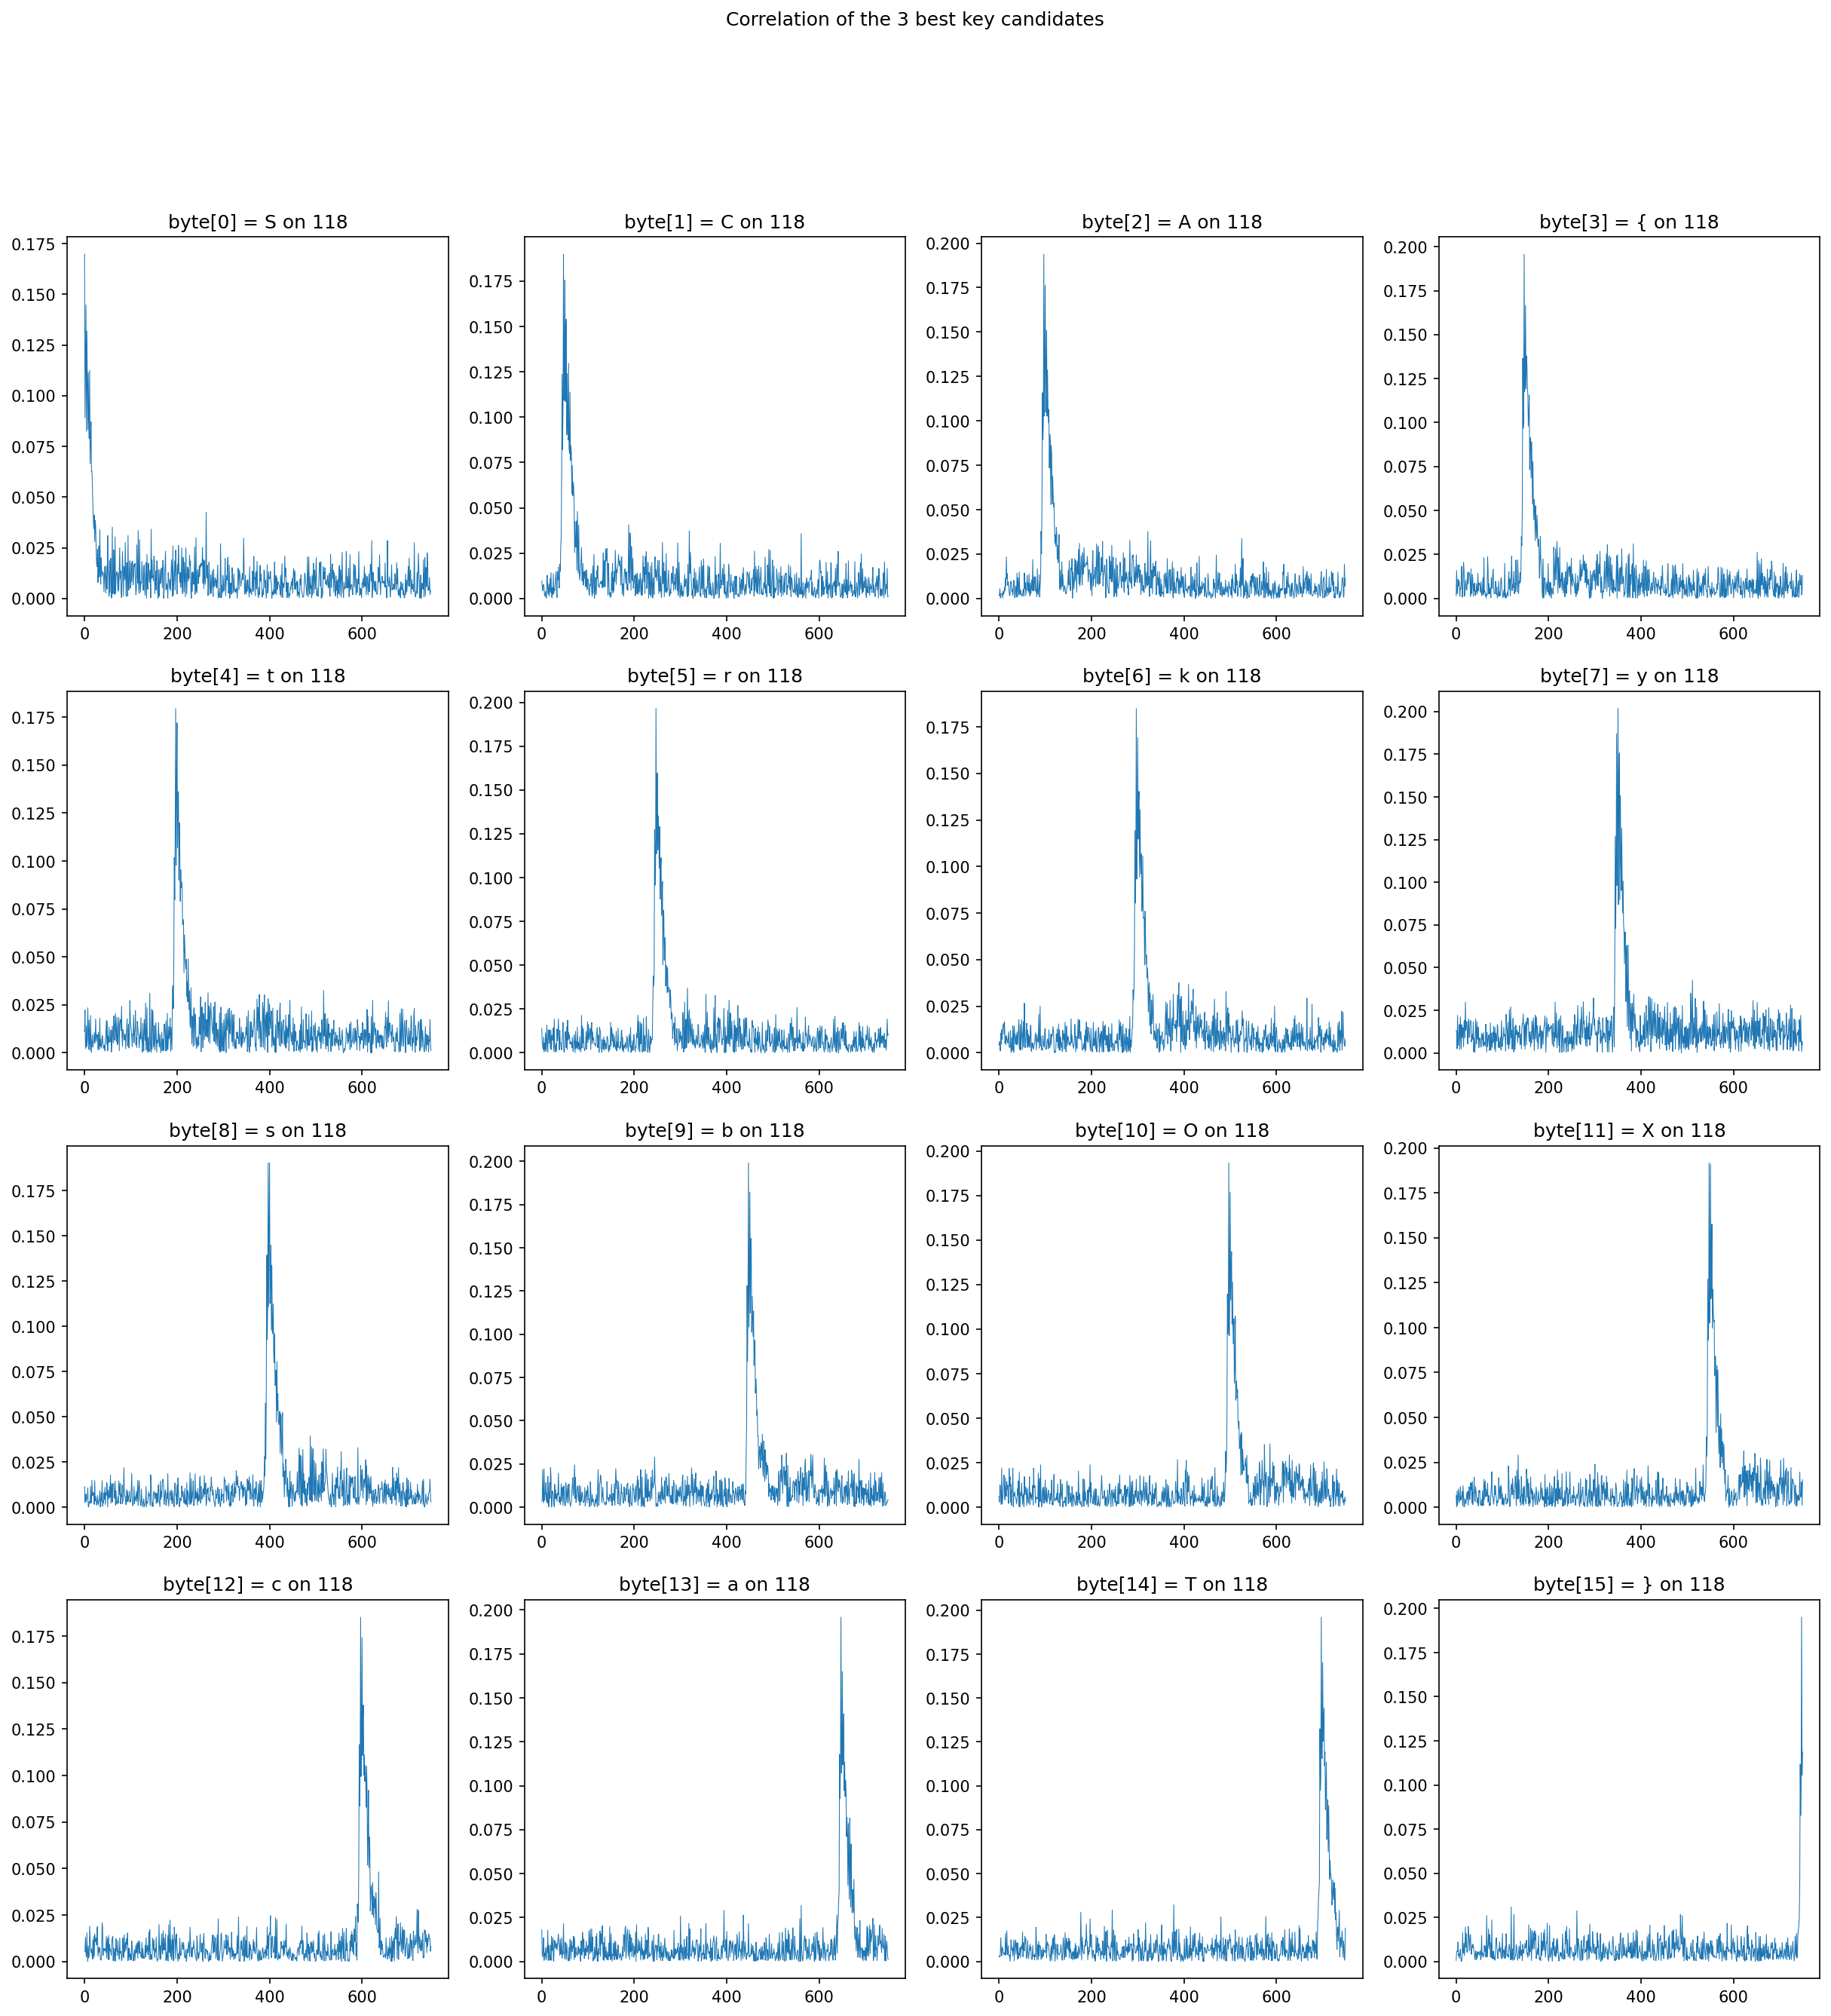

In [121]:
# Correlation visualisation
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20,20))
fig.suptitle("Correlation of the 3 best key candidates")
i = 0
for x in ax:
    for y in x:
        y.set_title(f"byte[{i}] = {flag[i]} on {ims[i]}")
        y.plot(corrs[i],label=i)
        i += 1